### Importing Libs

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TextVectorization

import torch
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import warnings
warnings.filterwarnings('ignore')

2023-08-31 00:16:36.549420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 00:16:41.375472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/krrish/.conda/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Verifying GPU Usage

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-30 20:45:37.338808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 20:45:37.441159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 20:45:37.441583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Reading Dataset

In [6]:
data = pd.read_csv("train.csv")
train_data = data[:int(0.8*159571)]
test_data = data[int(0.8*159571):]
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
train_data[train_data["threat"]==1][:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,I'm also a sock puppet of this account...SUPRI...,1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when ...",1,0,1,1,1,0
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1
1085,02f77830b4d71c0f,Whoever put a notices on my page. I will kill u,1,0,0,1,0,0
1312,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1
1535,0420f5f4e950566b,Demonte Morton \n\nU bastard stop deletin' my ...,1,0,1,1,1,1
1878,0512f33cf8807fa2,Aaron Swartz \n\nStop fucking reverting my god...,1,0,1,1,1,1
2018,057894cf4738a5d8,You are a gay homo. I hope you choke on your p...,1,0,1,1,1,1


### Visualization

(array([100838.,  16214.,   5278.,   2070.,    964.,    609.,    466.,
           386.,    313.,    518.]),
 array([   6. ,  505.4, 1004.8, 1504.2, 2003.6, 2503. , 3002.4, 3501.8,
        4001.2, 4500.6, 5000. ]),
 <BarContainer object of 10 artists>)

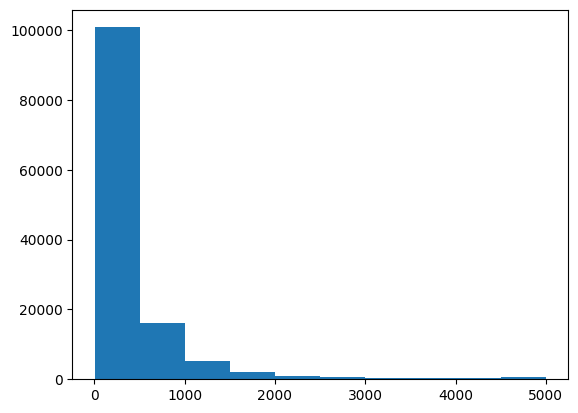

In [4]:
plt.hist([len(i) for i in train_data["comment_text"]])

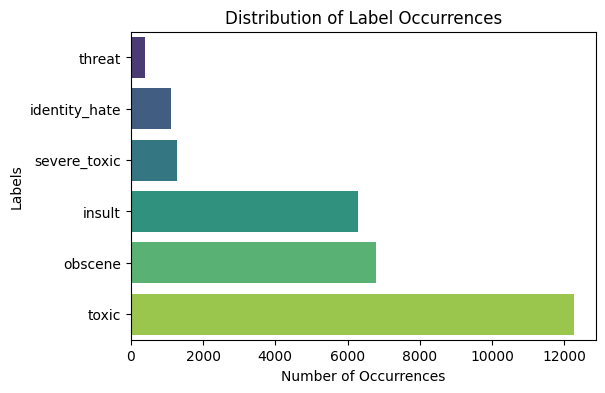

[  386  1100  1284  6295  6780 12257]


In [5]:
column_labels = train_data.columns.tolist()[2:]
label_counts = train_data[column_labels].sum().sort_values()

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')

plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
plt.show()
print(label_counts.values)

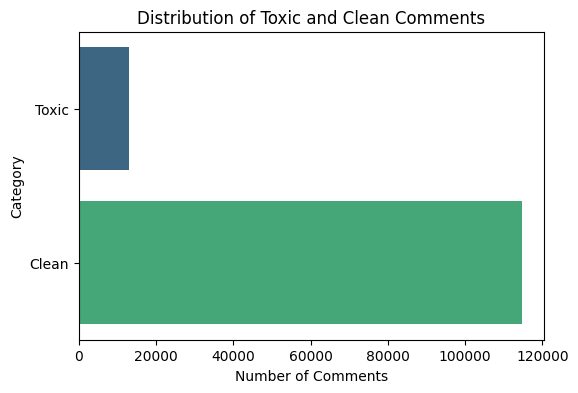

In [8]:
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(6, 4))

ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

ax.tick_params()

plt.show()

In [ ]:
print(train_data[train_data["threat"]==1 and train_data[column_labels].sum(axis=1) == 1])

<Axes: title={'center': 'Correlation of Toxicity Criteria with Each Other'}>

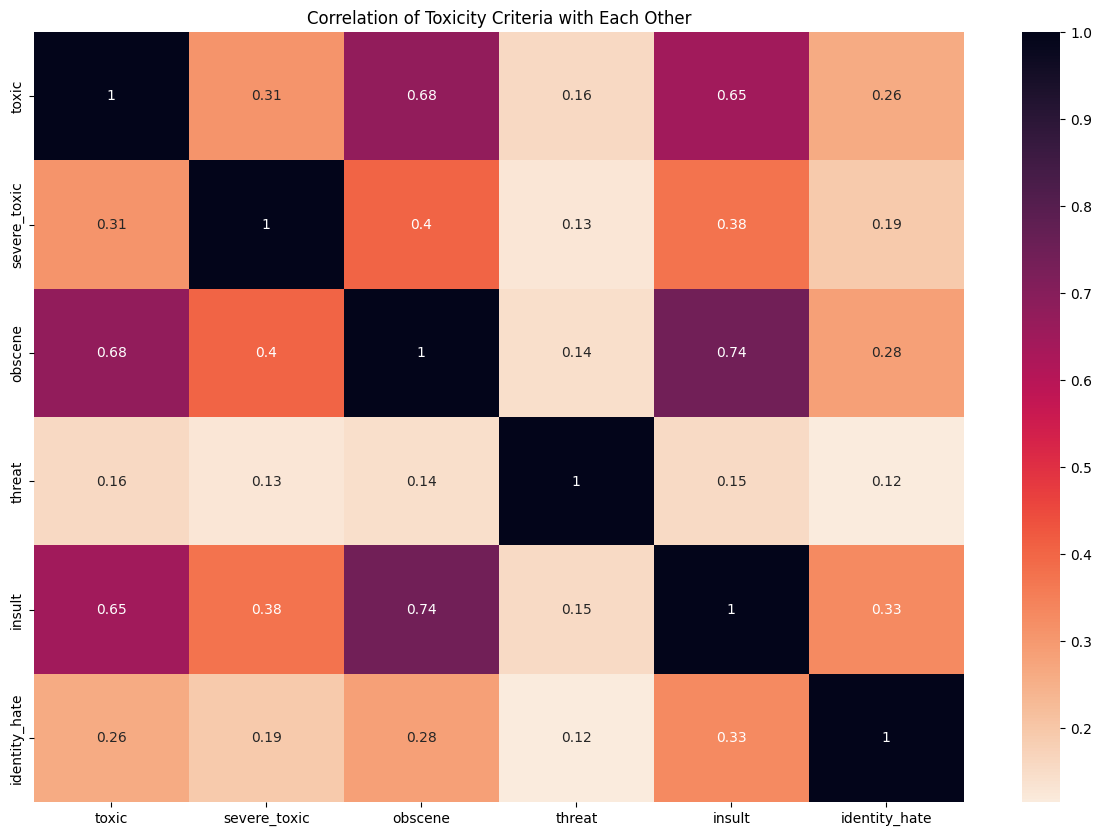

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))

labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
plt.title('Correlation of Toxicity Criteria with Each Other')

sns.heatmap(train_data[labels_list].corr(),cmap='rocket_r', annot=True)

In [10]:
non_toxic_undersample = train_data[train_data['toxic'] == 0].sample(n=(train_data['toxic'] == 1).sum(), random_state=201)
non_toxic_undersample
train_data = pd.concat([train_data[train_data['toxic'] == 1], non_toxic_undersample])

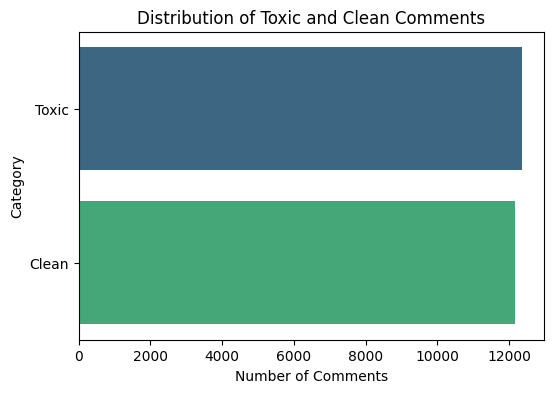

In [11]:
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(6, 4))

ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

ax.tick_params()

plt.show()

### Preprocessing

In [12]:
x_train = train_data["comment_text"]
y_train = train_data[train_data.columns[2:]].values
y_train

array([[1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [13]:
x_test = test_data["comment_text"]
y_test = test_data[test_data.columns[2:]].values
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [14]:
MAX_FEATURES = 200000 #Number of words in vocab

In [15]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

2023-08-30 20:45:44.261730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 20:45:44.261995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 20:45:44.262183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [16]:
vectorizer.adapt(x_train.values)
vectorized_train_text = vectorizer(x_train.values)

2023-08-30 20:45:47.024956: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 353001600 exceeds 10% of free system memory.


In [17]:
# vectorizer.adapt(x_test.values)
vectorized_test_text = vectorizer(x_test.values)

2023-08-30 20:45:47.644879: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 459576000 exceeds 10% of free system memory.


In [18]:
#MCSHBAP: map, cache, shuffle, batch, prefetch
train_dataset = tf.data.Dataset.from_tensor_slices((vectorized_train_text,y_train))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(160000)
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(8) #Prevents bottleneck
train_dataset.as_numpy_iterator().next()

2023-08-30 20:45:49.414661: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 353001600 exceeds 10% of free system memory.


(array([[ 456, 2162, 6566, ...,    0,    0,    0],
        [ 179,   24,   49, ...,    0,    0,    0],
        [  14,    2, 1079, ...,    0,    0,    0],
        ...,
        [  74,   29,    3, ...,    0,    0,    0],
        [ 943,    6,  256, ...,    0,    0,    0],
        [  16,   32,   18, ...,    0,    0,    0]]),
 array([[1, 0, 0, 0, 1, 0],
        [1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
       

In [19]:
#MCSHBAP: map, cache, shuffle, batch, prefetch
test_dataset = tf.data.Dataset.from_tensor_slices((vectorized_test_text,y_test))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(160000)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(8) #Prevents bottleneck
test_dataset.as_numpy_iterator().next()

2023-08-30 20:45:49.704937: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 459576000 exceeds 10% of free system memory.


(array([[    6,   232,    80, ...,     0,     0,     0],
        [  684,     1, 50953, ...,     0,     0,     0],
        [  180,     3,   811, ...,     0,     0,     0],
        ...,
        [ 1335,     4,    77, ...,     0,     0,     0],
        [  344,     7,   119, ...,     0,     0,     0],
        [    7,   734, 13750, ...,     0,     0,     0]]),
 array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],

In [20]:
x_batch, y_batch = train_dataset.as_numpy_iterator().next()
x_batch.shape,y_batch.shape

((32, 1800), (32, 6))

In [21]:
x_batch, y_batch = test_dataset.as_numpy_iterator().next()
x_batch.shape,y_batch.shape

((32, 1800), (32, 6))

### Model Creation (Bidirectional LSTM)


In [22]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation = "tanh")))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation="sigmoid"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 6466982 (24.67 MB)
Trainable params: 6466982 (24.67 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [24]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
model_history = model.fit(x = train_dataset,
                            epochs=10,
                            validation_data=test_dataset,
                          callbacks = [stop_early]
                            )

Epoch 1/10


2023-08-30 20:46:02.930587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-30 20:46:03.218503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f319ddcba10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-30 20:46:03.218532: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-08-30 20:46:03.224981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-30 20:46:03.260214: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/

767/767 [==============================] - 160s 194ms/step - loss: 0.2415 - accuracy: 0.9938 - val_loss: 0.0690 - val_accuracy: 0.9941
Epoch 2/10
767/767 [==============================] - 120s 156ms/step - loss: 0.1598 - accuracy: 0.9961 - val_loss: 0.0786 - val_accuracy: 0.9941
Epoch 3/10
767/767 [==============================] - 101s 132ms/step - loss: 0.1310 - accuracy: 0.9917 - val_loss: 0.0671 - val_accuracy: 0.9941
Epoch 4/10
767/767 [==============================] - 102s 132ms/step - loss: 0.1059 - accuracy: 0.9674 - val_loss: 0.0782 - val_accuracy: 0.8229
Epoch 5/10
767/767 [==============================] - 93s 122ms/step - loss: 0.0876 - accuracy: 0.9292 - val_loss: 0.1258 - val_accuracy: 0.9611


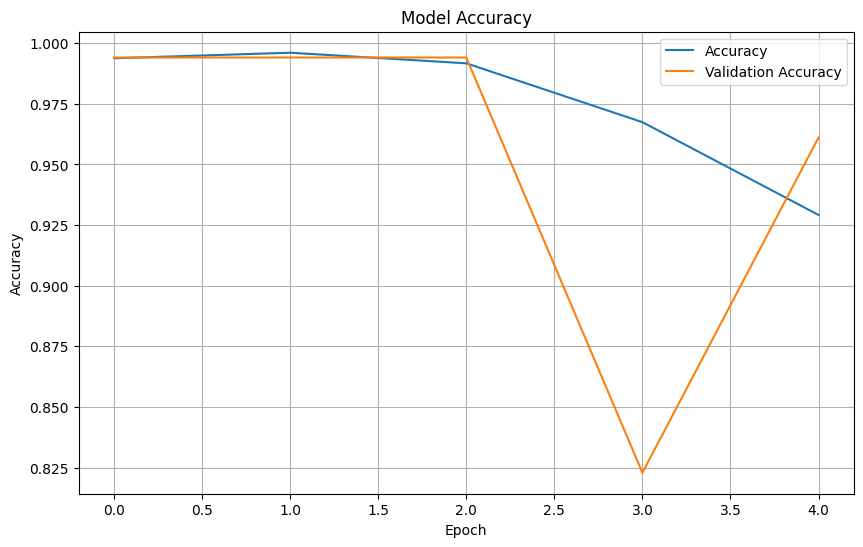

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['accuracy'], label='Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

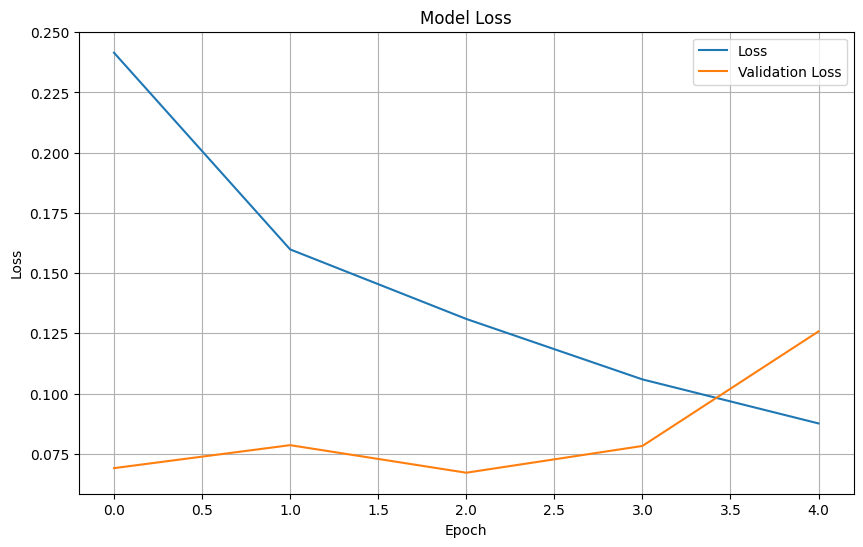

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['loss'], label='Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model.save("LSTM-Model")

INFO:tensorflow:Assets written to: LSTM-Model/assets


INFO:tensorflow:Assets written to: LSTM-Model/assets


### Using the model to predict

In [29]:
y_pred = model.predict(test_dataset)
y_pred = (y_pred>0.5).astype(int)

998/998 [==============================] - 29s 28ms/step


In [30]:
y_true = []
for i in test_dataset.as_numpy_iterator():
    for j in i[1]:
        y_true += [j]
y_true = np.array(y_true)

In [31]:
cm_y_pred = []
for i in y_pred:
    cm_y_pred += [i[0]]
cm_y_pred = np.array(cm_y_pred)    

In [32]:
cm_y_true = []
for i in y_true:
    cm_y_true += [i[0]]
cm_y_true = np.array(cm_y_true)

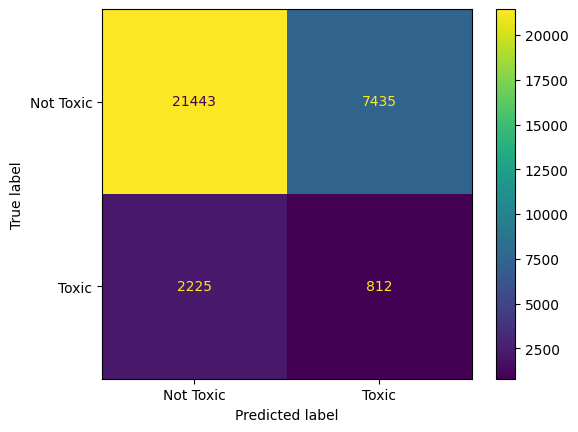

In [33]:
confusion_matrix = metrics.confusion_matrix(cm_y_true,cm_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Not Toxic","Toxic"])
cm_display.plot()

In [34]:
MAX_FEATURES = 200000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [35]:
train_data = pd.read_csv("train.csv")
x = train_data["comment_text"]

In [36]:
vectorizer.adapt(x.values)
vectorized_text = vectorizer(x.values)

2023-08-30 20:56:28.922274: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253720368 exceeds 10% of free system memory.


In [37]:
model1 = tf.keras.models.load_model('LSTM-Model')

In [38]:
input_text = vectorizer("Fuck your nigger ass")

In [39]:
res = model1.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 3s 3s/step


In [40]:
output = (res>0.5).astype(int)

In [41]:
col = train_data.columns[2:]
col = col.to_numpy()
col.shape

(6,)

In [42]:
count = 0
for index,element in np.ndenumerate(output):
  if(element==1):
    count = count+1
    _,k = index
    print(col[k])
if(count==0):
  print("Not Toxic")

Not Toxic


: 

### BERT

In [1]:
data = pd.read_csv("train.csv")
print(data.head())

NameError: name 'pd' is not defined

In [ ]:
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()

In [ ]:
train_toxic = data[data[column_labels].sum(axis=1) > 0]
train_clean = data[data[column_labels].sum(axis=1) == 0]

num_toxic = len(train_toxic)
num_clean = len(train_clean)

In [ ]:
train_clean_sampled = train_clean.sample(n=16225, random_state=42)
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)
dataframe = dataframe.sample(frac=1, random_state=42)

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
	dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)

In [ ]:
test_texts, val_texts, test_labels, val_labels = train_test_split(
	test_texts, test_labels, test_size=0.5, random_state=42)

In [ ]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
	input_ids = []
	attention_masks = []
	for comment in comments:
		encoded_dict = tokenizer.encode_plus(
			comment,
			add_special_tokens=False,
			max_length=max_length,
			pad_to_max_length=True,
			return_attention_mask=True,
			return_tensors='pt'
		)
		input_ids.append(encoded_dict['input_ids'])
		attention_masks.append(encoded_dict['attention_mask'])

	input_ids = torch.cat(input_ids, dim=0)
	attention_masks = torch.cat(attention_masks, dim=0)
	labels = torch.tensor(labels, dtype=torch.float32)

	return input_ids, attention_masks, labels

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=6)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
input_ids, attention_masks, labels = tokenize_and_encode(
	tokenizer,
	train_texts,
	train_labels.values
)
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
	tokenizer,
	test_texts,
	test_labels.values
)
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
	tokenizer,
	val_texts,
	val_labels.values
)

print('Training Comments :',train_texts.shape)
print('Input Ids		 :',input_ids.shape)
print('Attention Mask :',attention_masks.shape)
print('Labels		 :',labels.shape)

In [ ]:
batch_size = 16
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
def train_model(model, train_loader, optimizer, device, num_epochs):

	loss_line = []
	val_loss_line = []

	for epoch in range(num_epochs):

		model.train()
		total_loss = 0

		for batch in train_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			optimizer.zero_grad()

			outputs = model(
				input_ids, attention_mask=attention_mask, labels=labels)
			loss = outputs.loss
			total_loss += loss.item()

			loss.backward()
			optimizer.step()

		model.eval() 

		val_loss = 0
		with torch.no_grad():
			for batch in val_loader:
				input_ids, attention_mask, labels = [
					t.to(device) for t in batch]

				outputs = model(
					input_ids, attention_mask=attention_mask, labels=labels)
				loss = outputs.loss
				val_loss += loss.item()
		print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')
		loss_line += [total_loss/len(train_loader)]
		val_loss_line += [val_loss/len(val_loader)]
	
	plt.figure(figsize=(10, 6))
	plt.plot(loss_line, label='Loss')
	plt.plot(val_loss_line, label='Validation Loss')
	plt.title('Model Loss')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()
	plt.grid(True)
	plt.show()

train_model(model, train_loader, optimizer, device, num_epochs=10)

In [ ]:
def evaluate_model(model, test_loader, device):
	model.eval()

	true_labels = []
	predicted_probs = []

	with torch.no_grad():
		for batch in test_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			outputs = model(input_ids, attention_mask=attention_mask)
			predicted_probs_batch = torch.sigmoid(outputs.logits)
			predicted_probs.append(predicted_probs_batch.cpu().numpy())

			true_labels_batch = labels.cpu().numpy()
			true_labels.append(true_labels_batch)

	true_labels = np.concatenate(true_labels, axis=0)
	predicted_probs = np.concatenate(predicted_probs, axis=0)
	predicted_labels = (predicted_probs > 0.5).astype(int) 

	accuracy = accuracy_score(true_labels, predicted_labels)
	precision = precision_score(true_labels, predicted_labels, average='micro')
	recall = recall_score(true_labels, predicted_labels, average='micro')

	print(f'Accuracy: {accuracy:.4f}')
	print(f'Precision: {precision:.4f}')
	print(f'Recall: {recall:.4f}')

evaluate_model(model, test_loader, device)

In [ ]:
output_dir = "BERT-Model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

### Prediction using BERT

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = "BERT-Model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
	user_input = [input_text]

	user_encodings = tokenizer(
		user_input, truncation=True, padding=True, return_tensors="pt")

	user_dataset = TensorDataset(
		user_encodings['input_ids'], user_encodings['attention_mask'])

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

	model.eval()
	with torch.no_grad():
		for batch in user_loader:
			input_ids, attention_mask = [t.to(device) for t in batch]
			outputs = model(input_ids, attention_mask=attention_mask)
			logits = outputs.logits
			predictions = torch.sigmoid(logits)

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
	labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
	result = dict(zip(labels_list, predicted_labels[0]))
	return result

In [ ]:
predict_user_input(input_text="Your mother")